<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #2. Optional part
## <center> Implementation of the gradient boosting algorithm
    
#  <center>  <font color = 'red'> Warning! </font>This is a very useful but ungraded assignment

In this assignment, we will implement a the general gradient boosting algorithm -- the same class will implement a binary classifier that minimizes the logistic loss function and two regressors that minimize the mean squared error (MSE) and the root mean squared logarithmic error ([RMSLE](https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError)). This way, we will see that we can optimize arbitrary differentiable functions using gradient boosting and how this technique adapts in different contexts.

We will use the algorithm version from the [article](https://habrahabr.ru/company/ods/blog/327250/#klassicheskiy-gbm-algoritm-friedman-a) but with two simplifications:
1. We initialize the algorithm with the mean value of the vector $\large y$ i.e. $\large \hat{f_0} = \frac{1}{n}\sum_{i=1}^{n}y_i$.
2. We will make the learning rate constant: $\large \rho_t = const$.

There is a mapping between the pseudo code and the class parameters in `GradientBoosting`:

| What | Pseudo code &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;| `GradientBoosting` |
|:-----|:--------------------------------------|:-------------------|
| Training set  | $\large \{x_i, y_i\}_{i = 1,\ldots n}$ | `X`, `y` |
| Loss function | $\large L(y,f)$ | `objective` |
| Loss function gradient | $\large \frac{\partial L(y_i,f(x_i))}{\partial f(x_i)}$ | `objective_grad` |
| Number of iterations | $\large М$ | `n_estimators` |
| Base algorithm (decision tree regressor) | $\large h(x,\theta)$ | `DecisionionTreeRegressor` |
| Decision tree hyperparameters | $\large \theta$ | We will use only `max_depth` and `random_state`. |
| Learning rate<br>(coefficient for $\large h_t(x,\theta)$ in the composition) | $\large \rho_t, \quad t=1,\ldots,M$ | `learning_rate` |

## Deriving gradients for log_loss, MSE and RMSLE

Let's start with the traditional way of deriving formulas with pen and paper:
$\DeclareMathOperator{\logloss}{log\_loss}$
$\DeclareMathOperator{\MSE}{MSE}$
$\DeclareMathOperator{\RMSLE}{RMSLE}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\p}{\mathbf{p}}$

$$\begin{array}{rcl}
\logloss(\y, \p) &=& -\y\log \p + (1 - \y)\log (1 - \p) \\
&=& -\sum_{i=1}^{n}\left[y_i\log p_i + (1 - y_i)\log (1 - p_i)\right] \\
\\
\MSE(\y, \p) &=& \frac{1}{n}(\y - \p)^T(\y - \p) = \frac{1}{n}\sum_{i=1}^{n}(y_i - p_i)^2 \\
\\
\RMSLE(\y, \p) &=& \sqrt{\frac{1}{n} (\log (\p + 1) - \log (\y + 1))^T(\log (\p + 1) - \log (\y + 1))} \\
&=& \sqrt{\frac{1}{n} \sum_{i=1}^{n}(\log (p_i + 1) - \log (y_i + 1))^2}
\end{array}$$

where:

* $\y$ and $\p$ are **vectors** of values and predictions respectively.
* $\logloss$ takes the same values as in `scikit-learn` with $0$ and $1$ instead of $-1$ and $1$, as described in the main article.

**Question 1.** What is the expression for the `MSE` gradient?

$\begin{array}{rcl}
&& \text{1. } (\p - \y) && \text{3. } 2(\p - \y) \\
&& \text{2. } \frac{2}{n}(\y - \p) && \text{4. } \frac{2}{n}(\p - \y)
\end{array}$

**Question 2.** What is the expression for the `log_loss` gradient?

$\begin{array}{rcl}
&& \text{1. } \large \frac{\y - \p}{\y(1 - \y)} && \text{3. } \large \frac{\p - \y}{\p(1 - \p)} \\
&& \text{2. } \large \frac{\y - \p}{\p(1 - \p)} && \text{4. } \large \frac{\p - \y}{\y(1 - \y)}
\end{array}$

*Note:* division by a vector is element-wise, i.e. $\frac{1}{\p} = (\frac{1}{p_1}, \ldots \frac{1}{p_n})^T$.

**Question 3.** What is the expression for the `RMSLE` gradient?

$\begin{array}{rcl}
&& \text{1. } \frac{1}{n}(\p + 1)\RMSLE^{-1}(\y, \p) \log \frac{\p+1}{\y+1} && \text{3. } [n(\y + 1)\RMSLE(\y, \p)]^{-1} \log \frac{\p+1}{\y+1} \\
&& \text{2. } [n(\p + 1)\RMSLE(\y, \p)]^{-1} \log \frac{\p+1}{\y+1} && \text{4. } \frac{1}{n}\frac{\y+1}{(\p + 1)}\RMSLE^{-1}(\y, \p) \log \frac{\p+1}{\y+1}
\end{array}$

## Algorithm implementation

### Task:

Implement the `GradientBoosting` class using the following specification:
- The class inherits from `sklearn.base.BaseEstimator`.
- The constructor has the following parameters:

     - `loss` – a loss function to be optimized: `log_loss`, `mse` (by default) or `rmsle`;
     - `n_estimators` – the number of trees, that is, the number of boosting iterations (10 by default);
     - `learning_rate` – the learning rate ($10^{-2}$ by default);
     - `max_depth` – the maximum depth of a tree (3 by default);
     - `random_state` – the seed for the random number generator, only used for trees (17 by default).
     
- Depending on the value of `loss`, `objective` and `objective_grad` are initialized differently:

     - For `mse`, use `sklearn.metrics.mean_squared_error`;
     - For `log_loss`, use `sklearn.metrics.log_loss`;
     - For `rmsle`, you will need to implement the loss function by yourself as well as the gradients of all three loss functions. Also, don't leave out constants like $2$ or $n$ when computing the gradients.
     
- You will be using element-wise vector division in the implementations of the gradients for `log_loss` and `rmsle`. In order to avoid division by zero, replace all values less than $10^{-5}$ with $10^{-5}$, but do it only where it is absolutely neccesary. For example, when computing $\frac{y}{p}$, only replace the values in vector $p$.
- The constructor must create lists `loss_by_iter_` and `residuals_by_iter_` for debugging purposes and `trees_` for storing trained trees.
- The class must have methods `fit`, `predict`, and `predict_proba`:
    - The method `fit` takes a matrix `X` and a vector `y` (both are instances of `numpy.array`) as arguments, and returns the current instance of `GradientBoosting` i.e `self`. This method will implement the main logic of the algorithm. At each iteration, the current value of the loss function is stored in `loss_by_iter`, the value of the anti gradient (what we called *pseudo residuals* in the article) in `residuals_by_iter_`. Optionally, you could add a flag `debug=False` to the constructor arguments and store the anti gradient values when it is set to `True`. You must store each new trained tree in the `trees_` list.
    - The method `predict_proba` returns a linear combination of predictions over the trees. Don't forget the initial approximation. In the case of regression, the name of the method is somewhat misleading, but let's keep it so that we do not have to implement it twice for both the regressor and classifier. In the case of classification, apply $\sigma$-transformation to the returned value. In the impementation of the $\sigma$-function, replace arguments with absolute values larger than $100$ with $100$ or $-100$, depending on the sign of the argument, to prevent underflow or overflow.
    - In the case of regression, method `predict` returns a linear combination of predictions over all the trees (plus the initial aproximation) i.e. the same as the method `predict_proba`. In the case of classification, `predict` uses `predict_proba` and returns a vector composed of $0$s and $1$s obtained by comparing the predicted probabilities with a threshold that maximizes a share of correct answers on the training set. Here, it would be better to solve a one-dimensional optimization problem, but, for the sake of reproducibility, you should choose the threshold from `np.linspace(0.01, 1.01, 100)`.

### Solution:

In [1]:
import numpy as np
from tqdm import tqdm_notebook
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score, accuracy_score
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
class GradientBoosting(BaseEstimator):
    def __init__(self):
        pass

    def sigma(self, z):
        pass
    
    def log_loss(self, y, p):
        pass
    
    def log_loss_grad(self, y, p):
        pass
    
    def mse_grad(self, y, p):
        pass
    
    def rmsle(self, y, p):
        pass
    
    def rmsle_grad(self, y, p):
        pass
        
    def fit(self, X, y):
        pass
                 
    def predict_proba(self, X):
        pass
        
    def predict(self, X):
        pass

## Regression with a toy example

Prepare the dataset:

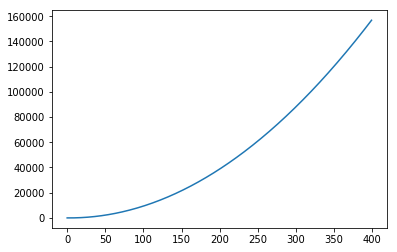

In [63]:
X_regr_toy = np.arange(400).reshape(-1, 1)

y_regr_toy = ((X_regr_toy - 3) ** 2).astype('float64')

plt.plot(X_regr_toy, y_regr_toy);

### Task:

Train an instance of the `GradientBoosting` regressor with the loss function `MSE` and the following input parameters: `learning_rate=0.1`, `max_depth=3`, `n_estimators=200`. Then, plot the change of the loss function over boosting iterations. You could also visualize the initial approximation and pseudo residuals on the first iterations as done in the article.

### Solution:

In [70]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

params = {'learning_rate': 0.1, 'max_depth':3, 'n_estimators':200}
reg = GradientBoostingRegressor(**params, criterion = 'mse')
reg.fit(X_regr_toy, y_regr_toy)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
mse = mean_squared_error(y_regr_toy, reg.predict(X_regr_toy))
mse

41488.049011142

### Task:

Train another `GradientBoosting` regressor with the same input parameters, but change the loss function to `RMSLE`. Plot the same values as in the previous task.

### Solution:

In [ ]:
#как обозначить функцию rmsle

## Classification with a toy example

Prepare the dataset:

In [80]:
X_clf_toy = np.c_[np.arange(7), (np.arange(7) - 3) ** 2]
y_clf_toy = np.array([0, 1, 0, 1, 0, 1, 0])

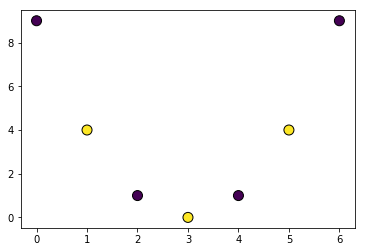

In [76]:
plt.scatter(X_clf_toy[:, 0], X_clf_toy[:, 1], c=y_clf_toy,
            s=100, edgecolors='black', linewidth=1);

### Task:

Train a classifier of type `GradientBoosting` with the loss function `log_loss` and the following parameters: `learning_rate=0.05`, `max_depth=3`, `n_estimators=10`. Then, plot the change of the loss function over boosting iterations. You could also visualize the initial approximation and pseudo residuals on the first iterations as done in the article.

### Solution:

In [89]:
params = {'learning_rate': 0.5, 'max_depth':3, 'n_estimators':10}
reg = GradientBoostingClassifier(**params, criterion = 'mse')
reg.fit(X_clf_toy, y_clf_toy)
round(log_loss(reg.predict(X_clf_toy), y_clf_toy), 2)

0.0

**Question 4.** For all $7$ objects in the toy dataset, calculate the predicted probabilities of being in the class $+1$? What are the two unique values in the computed vector?

1. $0.42$ and $0.77$
2. $0.36$ and $0.82$
3. $0.48$ and $0.53$
4. $0.46$ and $0.75$

## Regression with the Boston House-Prices Dataset

Prepare the dataset:

In [90]:
boston = load_boston()
X, y = boston.data, boston.target

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

### Task:

- Train a `GradientBoosting` regressor with the loss function `MSE` and the following parameters: `learning_rate=3`,  `max_depth=10`, `n_estimators=300`.
- Plot the change of the loss function over boosting iterations.
- Make predictions on the test set.
- Plot the distribution of `y_test`, which are the output variable values from the training set, along with the distribution of `test_pred`, which contains the values predicted by gradient boosting. Use the method `hist` from `matplotlib.pyplot` with the parameter `bins=15`.

### Solution:

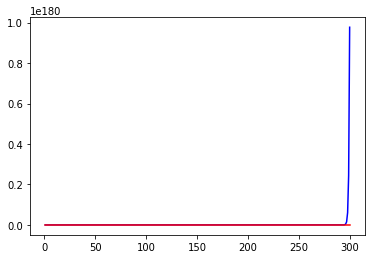

In [114]:
pars = {'learning_rate': 3, 'max_depth': 10, 'n_estimators': 300}
rgs = GradientBoostingRegressor(**pars, criterion = 'mse')
rgs.fit(X_train, y_train)
test_score = np.zeros((pars['n_estimators'],), dtype=np.float64)
plt.plot(np.arange(pars['n_estimators']) + 1, rgs.train_score_, 'b-')
plt.plot(np.arange(pars['n_estimators']) + 1, test_score, 'r-')

**Question 5.** Choose the correct statement regarding the resulting histograms:
1. On average, boosting predictions are overestimated by 10.
2. In the bin that contains the median of the answers on the test set (i.e. `numpy.median(y_test)`), there are more values from the vector of predictions `test_pred` than from the vector of answers `y_test`.
3. Sometimes our boosting algorithm predicts values that are far beyond the range of the `y_test` vector.

## Classification with the Breast Cancer Wisconsin Dataset

Prepare the dataset:

In [115]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [2]:
para = {'learning_rate': 0.1, 'max_depth':3, 'n_estimators':200}
rega = GradientBoostingClassifier(**para, criterion = 'mse')
rega.fit(X_train, y_train)

NameError: name 'GradientBoostingClassifier' is not defined

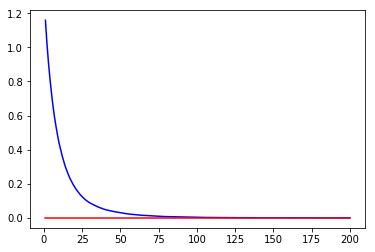

In [118]:
test_score = np.zeros((para['n_estimators'],), dtype=np.float64)
plt.plot(np.arange(para['n_estimators']) + 1, rega.train_score_, 'b-')
plt.plot(np.arange(para['n_estimators']) + 1, test_score, 'r-')

### Task:

- Train a `GradientBoosting` classifier with the loss function `log_loss` and the parameters `learning_rate=0.01`, `max_depth=3`, `n_estimators=200`.
- Plot the change of the loss function over boosting iterations.
- Make predictions on the test set: both the probabilities of being in the class $+1$ and binary predictions. 
- Calculate ROC AUC for the case of probabilites and the share of correct answers for binary predictions.

### Solution:

In [127]:
print(round(roc_auc_score(y_test, rega.predict(X_test)), 2), 
      round(accuracy_score(y_test, rega.predict(X_test), normalize=True), 2))

0.97 0.98


In [131]:
from sklearn.metrics import classification_report
classification_report(y_test, rega.predict(X_test))

'              precision    recall  f1-score   support\n\n           0       0.98      0.95      0.97        61\n           1       0.97      0.99      0.98       110\n\n   micro avg       0.98      0.98      0.98       171\n   macro avg       0.98      0.97      0.97       171\nweighted avg       0.98      0.98      0.98       171\n'

**Question 6.** What are the ROC AUC value and the share of correct predictions on the test set `(X_test, y_test)`?
1. $0.99$ and $0.97$
2. $1$ and $0.97$
3. $0.98$ and $0.96$
4. $0.97$ and $0.95$